In [1]:
import io
from pprint import pprint

import requests

import pydicom
import matplotlib.pyplot as plt
from pydicom import uid
from pydicom.filebase import DicomFileLike
from matplotlib.image import imread


def read_dicom_dataset(raw_data: bytes) -> pydicom.Dataset:
    """Permet de lire les bytes d'un fichier DICOM et le transformer en Dataset DICOM"""
    instance_uid = uid.generate_uid()
    buffer = io.BytesIO(raw_data)
    ds = pydicom.dcmread(buffer)

    return ds


def dicom_dataset_to_bytes(ds: pydicom.Dataset) -> io.BytesIO:
    """Permet d'écrire un Dataset DICOM en bytes"""
    buffer = io.BytesIO()
    memory_dataset = DicomFileLike(buffer)
    pydicom.dcmwrite(memory_dataset, ds)
    memory_dataset.seek(0)

    return buffer


def show_image_from_bytes(raw_data: bytes) -> None:
    buffer = io.BytesIO(raw_data)
    img = imread(buffer, format='png')

    plt.figure(figsize=(13, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


URL = 'https://progfest-rest.apps.valeria.science'

# <center>API REST : accéder à des données et des fonctionnalités via le web</center>

<br>
<center>Gabriel Couture, Félix-Antoine Fortin, Olivier Chouinard-Banville</center>

## Mise en situation

- Vous êtes un stagiaire en physique médiale
- Vous devez évaluer la qualité de traitements de radiothérapie
- Pour ce faire : vous allez créer des histogrammes dose-volume (DVH)

## Radiothérapie : cours express

<br>
<center><img src="../imgs/flot-radiotherapie.png" style="width: 700px;"></center>
<br>
<center><img src="../imgs/radiotherapy.png" style="width: 500px;"></center>

## Radiothérapie : images
Acquisition d'images (ex. CT)

<br>
<center><img src="../imgs/phantom-thorax.png" style="width: 300px;"></center>

## Radiothérapie : contours
- Tracé de structure (organes/région d'intérêt)

<table border="0">
 <tr>
    <td><img src="../imgs/contours.png" style="height: 300px;"></td>
    <td><img src="../imgs/structure.png" style="height: 300px;"></td>
 </tr>
</table>

## Radiothérapie : cours express
- Planification de la dose

<center><img src="../imgs/dose-distribution.png" style="width: 600px;"></center>

## Radiothérapie : cours express
- Données impliquées
    - Images CT
        - Fichier DICOM de type "__CT__"
    - Structure (région/organe dessiné)
        - Fichier DICOM de type "__RTStruct__"
    - Carte de dose (array en 3D de la dose délivrée)
        - Fichier DICOM de type "__RTDose__"
<center><img src="../imgs/ct-struct-dose.gif" style="width: 100%;"></center>

## Comment évaluer la qualité du traitement?

- Construire un histogramme dose-volume (DVH)!

<center><img src="../imgs/dvh-process.png" style="width: 600px;"></center>
<center><img src="../imgs/dvh-diff-to-cumulative.png" style="width: 600px;"></center>

## Résultat final : un DVH!
- ~100% de la cible reçoit la dose de prescription
- Organes sensibles épargnés autant que possible

<br>
<center><img src="../imgs/dvh-exemple.png" style="width: 700px;"></center>

## Atelier : ce qui est à faire

- Une API REST vous est mise à disposition. À partir de celle-ci, vous pourrez :
    - Récupérer des données
    - Anonymiser des données
    - Calculer des DVH
    - Et plus!

<center><img src="../imgs/atelier.png" style="width: 1200px;"></center>

## Données à manipuler

- 3 fichiers RTStruct (cylindre, shpère, cone)
- 1 fichier RTDose
<table border="0">
 <tr>
    <td><img src="../imgs/cylinder.png" style="height: 250px;"></td>
    <td><img src="../imgs/sphere.png" style="height: 250px;"></td>
    <td><img src="../imgs/cone.png" style="height: 250px;"></td>
    <td><img src="../imgs/dose-workflow.png" style="height: 250px;"></td>
 </tr>
</table>
Source : https://doi.org/10.1118/1.4923175

## Librairie Python `requests`

```python
response = requests.get(url='http://<url>/<route>', params={'key': 'value'})
response = requests.post(
    url='http://<url>/<route>',
    data={'key': 'value'},          # Pour les valeurs (str, float ou int)
    files={'key': bytes},           # Pour des fichiers (sous forme de bytes)
    json={'key': {'key': 'value'}}) # Pour des dictionnaires ou listes
response = requests.put(
    url='http://<url>/<route>',
    data={'key': 'value'},           # ...
    files={'key': bytes},            # ...
    json={'key': {'key': 'value'}})  # ...
response = requests.delete(url='http://<url>/<route>', params={'key': 'value'})
```

## Valider la connexion

- Validez d'abord que vous pouvez interagir avec l'API REST.

In [2]:
response = requests.get(f'{URL}')
print(response.status_code)
pprint(response.json())

200
{'message': "Bonjour et bienvenue à l'atelier sur les API REST!"}


## 1. Création d'un compte
- Pour créer un compte, soumetter votre IDUL via un POST à l'adresse `http://<url>/account`.
    - Dans le cadre de cet atelier, vous n'aurez pas besoin de mot de passe.
    - Vous pouvez soumettre votre idul de cette façon : 
        ```python
        response = resquests.post(
            url='http://<url>/account',
            data={'idul': 'votre-idul'}
        )
        ```
- Regardez le code HTTP (`response.status_code`) ainsi que le message (`response.text` ou `response.json()`).

In [3]:
response = requests.post(f'{URL}/account', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

409
{'error': '"gacou42" user already exits'}


## 2. Authentification

- Vous avez maintenant un compte, utilisez votre IDUL pour vous connecter!
- La route de l'API REST qui vous permet d'émettre un jeton d'authentification est `http://<url>/auth`
- Soumettez votre idul via un POST afin d'émettre un jeton (token)
- Ce jeton vous permettra valider votre identiter par la suite

In [4]:
response = requests.post(f'{URL}/auth', data={'idul': 'gacou42'})
print(response.status_code)
print(response.json())

200
{'token': 'e2a2f3d81a0de2ba37bb821c9e16c7960e21cf84'}


## 3. Récupération des données
- Vous avez maintenant votre `token` pour vous authentifier, il est désormais possible de récupérer les données.
- L'adresse où les données sont accessibles est `http://<url>/data`.
- Faites un GET, avec votre token en paramètre (`params={'token': '<votre-token>'}`) pour vérifier quelles données sont accessibles.

In [5]:
TOKEN = response.json()['token']

response = requests.get(f'{URL}/data', params={'token': TOKEN})
print(response.json())

['sphere', 'cylinder', 'cone', 'dose']


## 3.1 Récupération des données

- Vous devriez observer 4 données
- Pour les récupérer, faites un GET à `http://<url>/data/<nom-donnée>` avec le token en paramètre
- Le contenu de la réponse est un fichier binaire (`response.content`).
    - Pour le transformer en `Dataset` :
        - `dataset = read_dicom_dataset(response.content)`

In [6]:
response = requests.get(f'{URL}/data/sphere', params={'token': TOKEN})
sphere = read_dicom_dataset(response.content)

response = requests.get(f'{URL}/data/cylinder', params={'token': TOKEN})
cylinder = read_dicom_dataset(response.content)

response = requests.get(f'{URL}/data/cone', params={'token': TOKEN})
cone = read_dicom_dataset(response.content)

response = requests.get(f'{URL}/data/dose', params={'token': TOKEN})
dose = read_dicom_dataset(response.content)

## 3.2 Récupération des données
- Maintenant que vous avez les 4 `Dataset`, vérifiez s'ils contiennent des informations personnelles.
    - Observez l'attribut `dataset.PatientName` pour voir s'il contient un nom personnel.
    

In [7]:
print(sphere.PatientName)
print(cylinder.PatientName)
print(cone.PatientName)
print(dose.PatientName)

Gabriel Couture
Gabriel Couture
Gabriel Couture
Gabriel Couture


## 4. Anonymisation des données
- En santé, il est important de manipuler des données anonymes lors des activités de recherche.
- Pour anonymisé un `Dataset`
    1. Transformez le en `bytes` avec la fonction 
        - `dataset_bytes = dicom_dataset_to_bytes(dataset)`
    2. Faire un POST à `http://<url>/anonymize` avec le dataset en bytes en tant que fichier
        - `requests.post(..., files={'file': dataset_bytes})`
    3. Récupérer la réponse et transformez la en dataset 
        - `dataset = read_dicom_dataset(response.content)`
   

## 4. Anonymisation des données


In [8]:
sphere_bytes = dicom_dataset_to_bytes(sphere)
response = requests.post(f'{URL}/anonymize', files={'file': sphere_bytes})
sphere = read_dicom_dataset(response.content)

cylinder_bytes = dicom_dataset_to_bytes(cylinder)
response = requests.post(f'{URL}/anonymize', files={'file': cylinder_bytes})
cylinder = read_dicom_dataset(response.content)

cone_bytes = dicom_dataset_to_bytes(cone)
response = requests.post(f'{URL}/anonymize', files={'file': cone_bytes})
cone = read_dicom_dataset(response.content)

dose_bytes = dicom_dataset_to_bytes(dose)
response = requests.post(f'{URL}/anonymize', files={'file': dose_bytes})
dose = read_dicom_dataset(response.content)

## 4.1 Anonymisation des données
- Vérifiez si les `Dataset` ont toujours de l'informations personnelles (`dataset.PatientName`).

In [9]:
print(sphere.PatientName)
print(cylinder.PatientName)
print(cone.PatientName)
print(dose.PatientName)

^
^
^
^


## 5. Calculer des DVH

- Maintenant que vous avez des données anonymes, vous pouvez obtenir les DVH.
- Pour chaque structure :
    1. Transformez les datasets de structure et de dose en `bytes` avec la fonction `dicom_dataset_to_bytes`
    2. Faites un POST à `http://<url>/dvh`, les dataset en bytes en tant que fichiers `files={'file_struct': struct_bytes, 'file_dose': dose_bytes}`
    3. Récupérez les réponses sous le format JSON (`response.json()`).

In [10]:
dvhs = []

for struct in [sphere, cylinder, cone]:
    response = requests.post(
        f'{URL}/dvh',
        files={
            'file_struct': dicom_dataset_to_bytes(struct),
            'file_dose': dicom_dataset_to_bytes(dose)
        }
    )
    dvhs.append(response.json())

## 6. Tracer des DVH

- Maintenant que vous avez les données des DVH, vous pouvez tracer un graphique.
- Pour ce faire, faites un POST à `http://<url>/dvh/plot`.
- Le post doit contenir les informations suivantes :
```python
requests.post(
    ...,
    json={
        'dvhs': [
            {'name': ..., 'volumes': ..., 'doses': ..., 'volume_units': ..., 'dose_units': ...},
            {'name': ..., 'volumes': ..., 'doses': ..., 'volume_units': ..., 'dose_units': ...}
            ...
        ]
    }
)
```

## 6. Tracer des DVH

In [11]:
response = requests.post(
    f'{URL}/dvh/plot',
    json={'dvhs': dvhs}
)
print(response.status_code)

200


## 6.1 Tracer des DVH
- Le contenu de la réponse est une image `.png` des DVH. Vous pouvez l'afficher avec la fonction `show_image_from_bytes(response.content)`. 

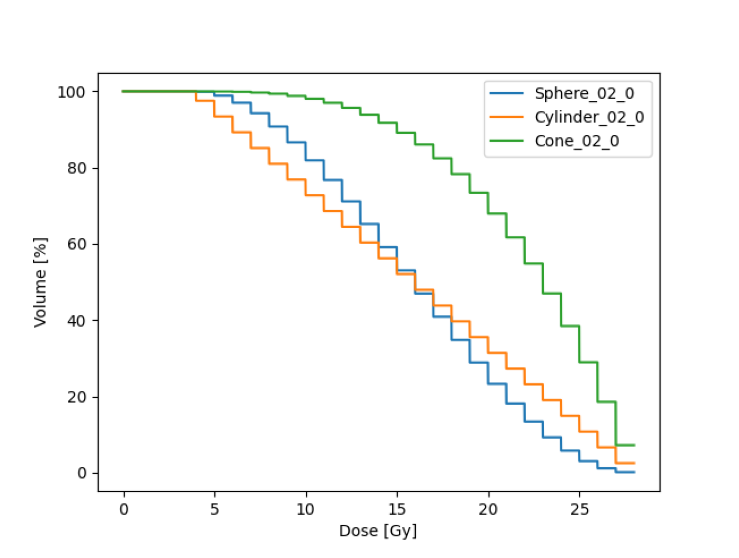

In [12]:
show_image_from_bytes(response.content)

## Félicitations, vous avez obtenu des DVH!

- Maintenant que vous savez manipuler une API REST, vous pouvez allez voir comment en faire une. 
    - La librairie utilisée pour construire l'API REST utilisée dans cet atelier est celle-ci https://flask-restful.readthedocs.io/en/latest/quickstart.html.
    - L'API REST utilisée dans cet atelier se trouve ici : https://github.com/ulaval-rs/prog-fest-web-workshop/blob/main/app.py.